## Objectives:

To implement an exponential model for CoVid-19 confirmed cases for every country.
The model may be implemented in three ways:
1. Unpooled (with different priors for each country)
2. Pooled (with same priors for each country)
3. Hierarchical (with same hyper-priors, but different priors for each country)

This notebook shows all three implementations using pyMC3 and their analysis.


A justification for using an exponential model is provided in the `Rationale` section.

Inspired from [Thomas Wiecki's CoVid-19](https://github.com/twiecki/covid19) notebooks.

**Note**: The notebook uses the `interact` widget. Please fork it and view in editor to interact with the output.

In [1]:
import numpy as np 
import pandas as pd 
from pathlib import Path

import pymc as pm
import arviz as az

import cufflinks as cf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_squared_error
from ipywidgets import interact, interact_manual, fixed

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('use_inf_as_na', True)
cf.set_config_file(offline=True, theme='pearl');
path = Path("data/")

/var/folders/5x/vz4_nh_d6f5ds1c71xs4q_n0qqgwj_/T/ipykernel_65103/2430209213.py:2: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



In [3]:
master_df = pd.read_csv(path/'covid_19_data.csv')

In [4]:
recovered_df = (pd.read_csv(path/'time_series_covid_19_recovered.csv')
                .drop(columns=['Lat', 'Long', 'Province/State'])
                .groupby('Country/Region')
                .sum())

deaths_df = (pd.read_csv(path/'time_series_covid_19_deaths.csv')
             .drop(columns=['Lat', 'Long', 'Province/State'])
             .groupby('Country/Region')
             .sum())

confirmed_df = (pd.read_csv(path/'time_series_covid_19_confirmed.csv')
                .drop(columns=['Lat', 'Long', 'Province/State'])
                .groupby('Country/Region')
                .sum())

## Rationale

An exponential model is given by:

$ y' = y_{0} * (1 + b)^x $

where, $b$ is the growth rate

By taking a logarithmic transform, we obtain a (log-linear) regression model

$ \implies ln(y') = ln(y_{0}) + x*ln(1 + b)$

$\implies y = \alpha + \beta * x$

Graphically, we can validate that a distribution follows a exponential growth model by plotting $ln(y)$ against $x$.
If the graph shows a linear relationship, we can solve for $\alpha$ and $\beta$ using linear regression techniques. 

Values for $a$ and $b$ can be obtained by:
* $ y_{0} = e^{\alpha}$
* $ b = e^{\beta} - 1$

In [5]:
# sorted_country_list = confirmed_df.sort_values(by=confirmed_df.columns[-1], ascending=False).index.to_list()
sorted_country_list = confirmed_df.index

In [6]:
@interact(country=sorted_country_list, threshold=(1, 1000, 10), fit=True)
def log_lin_visualise(country, fit, threshold=100):
    
    y = confirmed_df.filter(items=[country], axis=0).values.squeeze(0).astype(float)
    y = np.log(y[y > threshold])
    x = np.arange(1, y.shape[0] + 1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, label='Observed')
    
    if fit:

        lr = LinearRegression()
        lr.fit(X=x.reshape(-1, 1) , y=y)
        α, β =  lr.intercept_, lr.coef_

        y_fitted = lr.predict(X=x.reshape(-1, 1))

        print("Solving linear regression using OLS ... ")
        print(f"* r2_score = {round(r2_score(y, y_fitted), 2)}")
        print(f"* mean_squared_error = {round(mean_squared_error(y, y_fitted), 2)}")

        plt.plot(x, y_fitted, label=f"{round(α, 2)} + {round(β[0], 2)}*x")

    plt.xlabel(f'Days Since {threshold}th Case')
    plt.ylabel('Natural Logarithm of Confirmed Cases')
    plt.legend()
    plt.title(country)
    plt.show()
    plt.close()

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

#### Observation

We can clearly observe a linear relationship between $ln(y)$ and $x$ for highly infected countries (except China and S. Korea)

## Model

### Unpooled Model

Different priors for every country. 

This model needs to be run separately for each country.

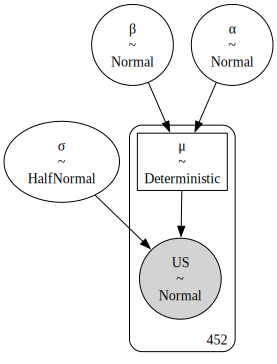

In [7]:
country = 'US'
threshold = 100

y = confirmed_df.filter(items=[country], axis=0).values.squeeze(0)
y = np.log(y[y > threshold])
x = np.arange(1, y.shape[0] + 1)


with pm.Model() as unpooled_model:
    
    
    # priors
    α = pm.Normal(name='α', mu=int(np.log(threshold)), sigma=10)
    β = pm.Normal(name='β')
    
    # error
    σ = pm.HalfNormal(name='σ', sigma=10)
    
    # expected value
    μ = pm.Deterministic(name='μ', var= α + β*x)
    
    # liklihood == 'prior_predictive'
    pm.Normal(name=country, mu=μ, sigma=σ, observed=y)
    
    pm.model_to_graphviz().save('unpooled_model.png')
    
pm.model_to_graphviz(unpooled_model)

In [8]:
## shape-sanity checks

# ((β.random()*x) + α.random()).shape
# Y[4].shape

# idx = [0, 0, 1, 1, 1, 4]
# α.random()[idx]

In [9]:
with unpooled_model:
    
    # sampling liklihood
    prior = pm.sample_prior_predictive()
    
    # posterior
    trace = pm.sample()
    
    # predictions == 'posterior_predictive'
    pred = pm.sample_posterior_predictive(trace)

Sampling: [US, α, β, σ]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [US]


Output()

In [10]:
def custom_from_pymc3(trace, prior, pred):
    unpooled = az.convert_to_inference_data(trace)
    unpooled.extend(pred)
    unpooled.extend(prior)
    return unpooled

In [11]:
# unpooled = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=pred, model=unpooled_model)
unpooled = custom_from_pymc3(trace, prior, pred)
# unpooled = az.convert_to_inference_data(trace)
# unpooled.extend(pred)
# unpooled.extend(prior)
# if 'log_likelihood' not in unpooled:
#     with unpooled_model:
#         log_likelihood_data = pm.compute_log_likelihood(unpooled)
# unpooled.add_groups(log_likelihood=log_likelihood_data)
prior_vars = ['α', 'β', 'σ']
unpooled

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [12]:
unpooled.posterior['α'].shape

(4, 1000)

In [13]:
summary_df = az.summary(unpooled)
summary_df.to_csv(f'unpooled_{country}_summary.csv')

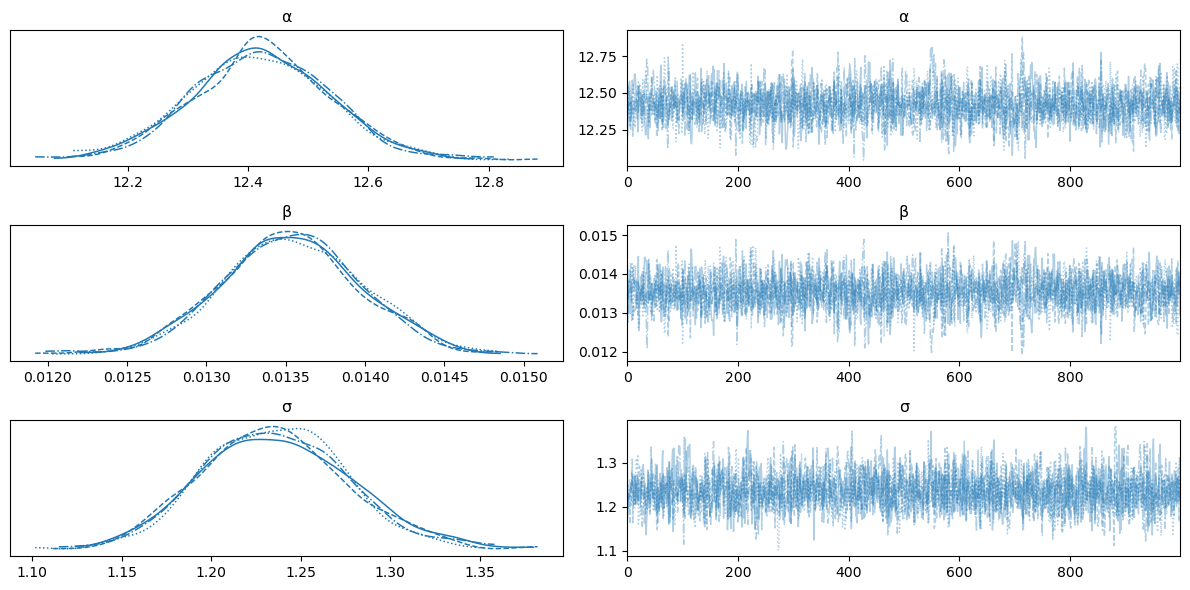

In [14]:
az.plot_trace(data=unpooled, var_names=prior_vars);
plt.tight_layout()

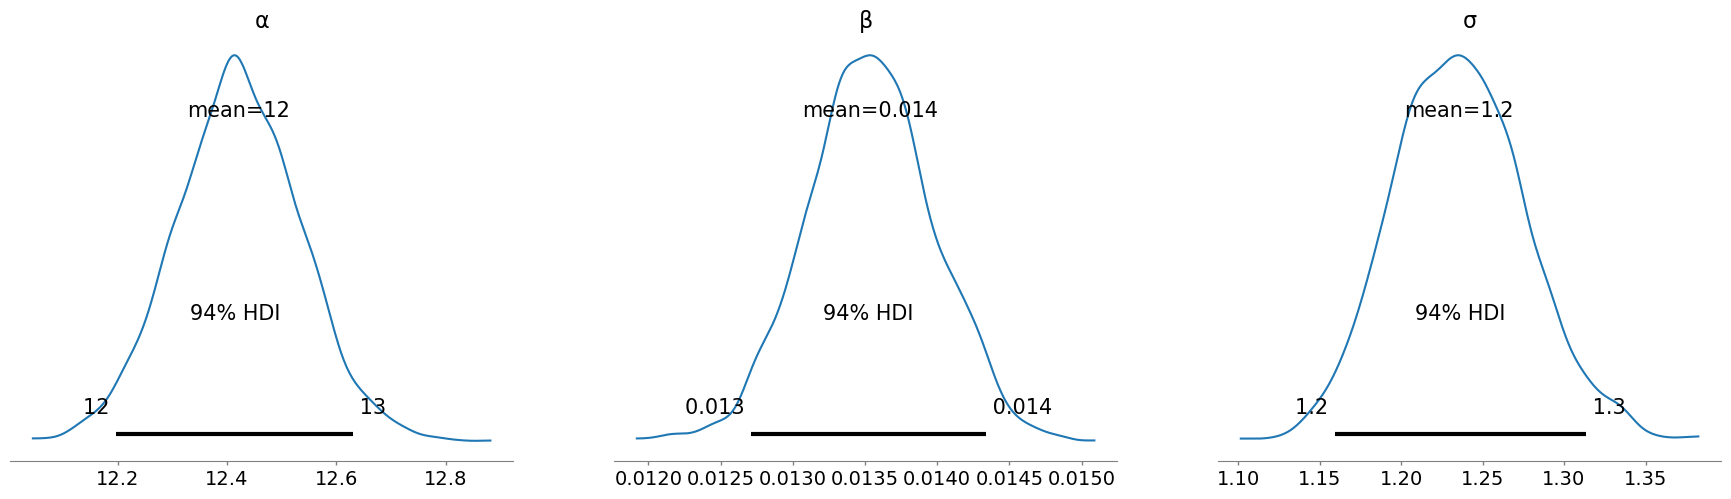

In [15]:
az.plot_posterior(data=unpooled, var_names=prior_vars, group='posterior');

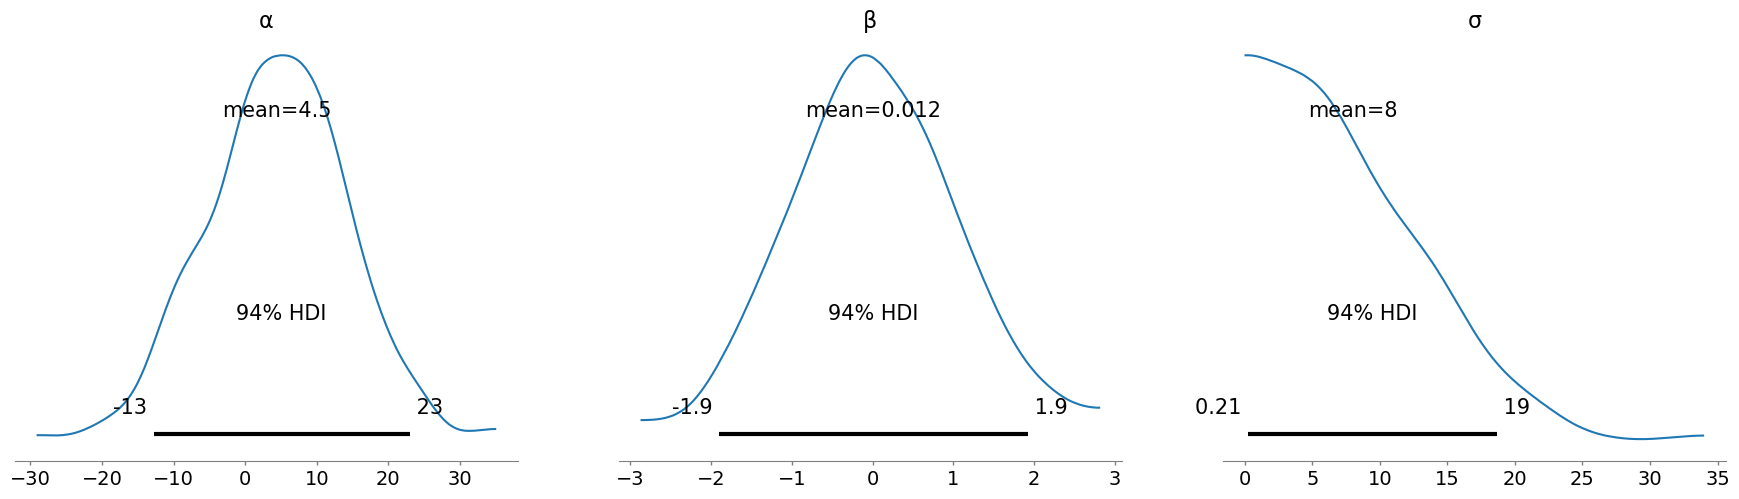

In [16]:
az.plot_posterior(data=unpooled, var_names=prior_vars, group='prior');

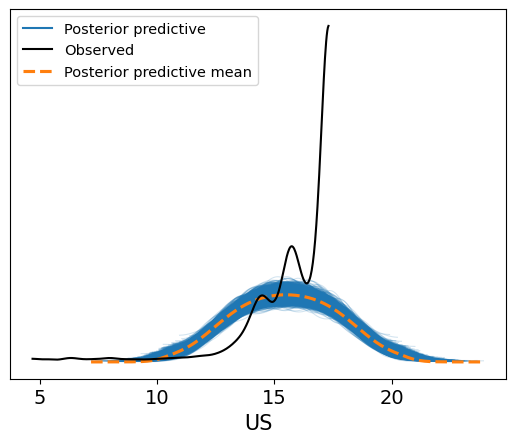

In [17]:
az.plot_ppc(data=unpooled, group='posterior');

In [18]:
# pm.find_MAP(model=unpooled_model)

In [19]:
mean_priors = az.summary(unpooled).filter(items=prior_vars, axis=0)['mean']
y_fitted = mean_priors['α'] + mean_priors['β']*x

mean_priors

α    12.421
β     0.014
σ     1.236
Name: mean, dtype: float64

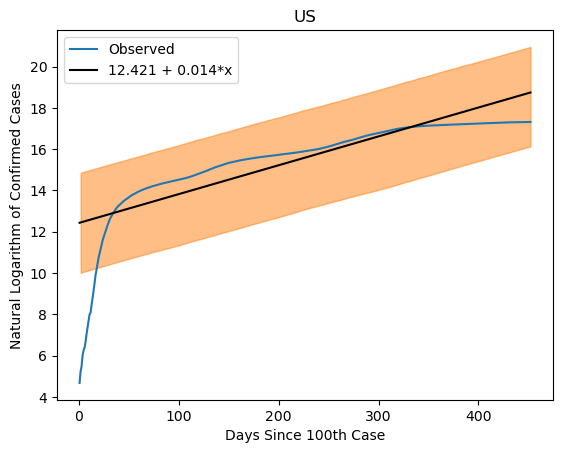

In [22]:
ci = 0.95


az.plot_hdi(x=x, y=unpooled.posterior_predictive[country], hdi_prob=ci)#, plot_kwargs={'label': f'Predictions ({ci})'});
# az.plot_hpd(x=x, y=unpooled.posterior['μ'], color='C2', credible_interval=ci)#, plot_kwargs={'label': f'Expectation ({ci})'});
plt.plot(x, y, label='Observed');
plt.plot(x, y_fitted, label=f"{mean_priors['α']} + {mean_priors['β']}*x", color='k');

plt.xlabel(f'Days Since {threshold}th Case')
plt.ylabel('Natural Logarithm of Confirmed Cases')
plt.title(country)
plt.legend()
plt.show()
plt.close()

In [23]:
az.r2_score(y_true=y, y_pred=unpooled.posterior_predictive[country].data.reshape(-1, y.shape[0]))

r2        0.604232
r2_std    0.018868
dtype: float64

In [24]:
# az.plot_dist(unpooled.log_likelihood[country]);
# az.plot_dist(unpooled.prior_predictive[country]);

In [25]:
## Mean of predicted values

y_fitted = unpooled.posterior_predictive[country].data.reshape(-1, y.shape[0]).mean(axis=0)
print(f"r2_score = {round(r2_score(y, y_fitted), 2)}")
print(f"mean_squared_error = {round(mean_squared_error(y, y_fitted), 2)}")

r2_score = 0.67
mean_squared_error = 1.51


In [26]:
## Mean of expected values

y_fitted = unpooled.posterior['μ'].data.reshape(-1, y.shape[0]).mean(axis=0)
print(f"r2_score = {round(r2_score(y, y_fitted), 2)}")
print(f"mean_squared_error = {round(mean_squared_error(y, y_fitted), 2)}")

r2_score = 0.67
mean_squared_error = 1.51


#### Finding appropriate start date for all data
For both `pooled` and `hierarchical`

In [27]:
# Data for all counties needs to be in similar dimensions.

cumulative_threshold = 1e4 # to select countries
threshold = 100 # to select start_date

high_confirmed_df = confirmed_df[confirmed_df.iloc[:, -1] > cumulative_threshold]
high_confirmed_df = high_confirmed_df.where(cond=lambda x: x > threshold, other=np.nan) # or -1

In [28]:
# Dropping for now
# high_confirmed_df = high_confirmed_df.drop(index=['China', 'Korea, South'])

In [29]:
majority = high_confirmed_df.shape[0]/2

high_confirmed_df.isna().sum().iplot(hline=majority,
                                     xTitle='Date', yTitle=f'Countries below {threshold} cases', 
                                     title='Threshold Cases for Highly Infected Countries');

In [30]:
cross_over_date = (high_confirmed_df.isna().sum() < majority).idxmax()
cross_over_date

'3/23/20'

#### Preparing data 
For both `pooled` and `hierarchical`

In [31]:
thresholded_high_confirmed_df = high_confirmed_df.iloc[:, high_confirmed_df.columns.to_list().index(cross_over_date):]
thresholded_high_confirmed_df = thresholded_high_confirmed_df.dropna(how='any', axis=0)
thresholded_high_confirmed_df = thresholded_high_confirmed_df.applymap(np.log)

print(thresholded_high_confirmed_df.shape)

(77, 433)


/var/folders/5x/vz4_nh_d6f5ds1c71xs4q_n0qqgwj_/T/ipykernel_65103/1674293464.py:3: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [32]:
n_countries = thresholded_high_confirmed_df.shape[0]
date_points = thresholded_high_confirmed_df.shape[1]
idx = np.repeat(a=np.arange(n_countries), repeats=date_points)

### Pooled Model

Shared/ grouped priors between all countries

In [33]:
x = np.arange(1, date_points + 1)
XX = np.stack([x]*n_countries, axis=0)

YY = thresholded_high_confirmed_df.values

print(XX.shape, YY.shape)

(77, 433) (77, 433)


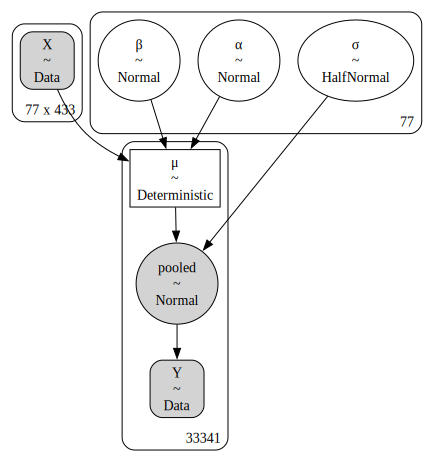

In [34]:
# vectorised implementation
'''
Here, 
    μ.shape = (440,)
    σ[idx].shape = (440,) 
    Y.flatten().shape = (440,)
Data for each country is repeated, so first 40 points (index 0 to 39) are of first country, 
second 40 points (index 40 to 79) are of second country and so on.
'''


def split_and_pack(labels, data, axis=2):
    '''
    Helper function to unpack values from a vectorised output
    '''
    splits = np.split(ary=data, axis=axis, indices_or_sections=len(labels))
    d = dict(zip(labels, data))
    return d
    

with pm.Model() as pooled_model:

    
    X = pm.Data(name='X', value=XX)
    Y = pm.Data(name='Y', value=YY.flatten())
    
    # priors
    α = pm.Normal(name='α', mu=int(np.log(threshold)), sigma=10, shape=n_countries)
    β = pm.Normal(name='β', sigma=5, shape=n_countries)
    
    # error
    σ = pm.HalfNormal(name='σ', sigma=10, shape=n_countries)
    
    # expected value
    
    μ = pm.Deterministic(name='μ', var= (α + β*X.T).T.flatten())
    
    # liklihood == 'prior_predictive'
    pm.Normal(name='pooled', mu=μ, sigma=σ[idx], observed=Y)
    
    pm.model_to_graphviz().save('pooled_model.png')
    
pm.model_to_graphviz(pooled_model)

In [35]:
# non-vectorised implementation
# '''
# All three parameters (mu, sd, observed) have to be of the same shape / broadcasteble
# Here, 
#     μ[i].shape = (40,)
#     σ[i].shape = (1,) # broadcasted to (40,)
#     Y[i].shape = (40,)
# '''

# with pm.Model() as pooled_model:

#     X = pm.Data(name='X', value=X)
#     Y = pm.Data(name='Y', value=Y) # not using it since we will iterate over the dataframe
    
#     # priors
#     α = pm.Normal(name='α', mu=int(np.log(threshold)), sd=10, shape=n_countries)
#     β = pm.Normal(name='β', sd=5, shape=n_countries)
    
#     # error
#     σ = pm.HalfNormal(name='σ', sd=10, shape=n_countries)
    
#     # expected value -- Deterministic matrix μ
#     ## transpose is necessary because operations are performed row-major style
# #     μ = pm.Deterministic(name='μ', var= (α + β*X.T).T) 
    
#     # liklihood == 'prior_predictive'
#     for i, (index, row) in enumerate(thresholded_high_confirmed_df.iterrows()):
        
#         # use with Deterministic matrix μ
# #       pm.Normal(name=index, mu=μ[i], sd=σ[i], observed=row.values) 
        
# #         μ = α[i] + β[i]*x
#         μ = pm.Deterministic(name=f'μ_{index}', var= α[i] + β[i]*X[i])  # to save μ in the trace
#         pm.Normal(name=index, mu=μ, sd=σ[i], observed=Y[i])  # or row.values
            
# pm.model_to_graphviz(pooled_model)

In [36]:
## shape-sanity checks

# ((β.random()*X.T) + α.random()).T.shape
# Y[4].shape

# idx = [0, 0, 1, 1, 1, 4]
# α.random()[idx]

In [37]:
with pooled_model:
    
    # sampling liklihood
    prior = pm.sample_prior_predictive()
    
    # posterior
    trace = pm.sample()
    
    # predictions == 'posterior_predictive'
    pred = pm.sample_posterior_predictive(trace)

Sampling: [pooled, α, β, σ]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 287 seconds.
Sampling: [pooled]


Output()

In [40]:
# pooled = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=pred, model=pooled_model)
pooled = custom_from_pymc3(trace, prior, pred)
prior_vars = ['α', 'β', 'σ']
pooled

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [ ]:
# pm.find_MAP(model=pooled_model)

In [41]:
pooled.posterior['α'].shape # chains x samples x n_countries

(4, 1000, 77)

In [42]:
summary_df = az.summary(pooled) 
summary_df.to_csv('pooled_summary.csv')

In [43]:
countries = thresholded_high_confirmed_df.index.to_list()
means = {var : split_and_pack(data=summary_df.filter(like=var, axis=0)['mean'], labels=countries, axis=0) for var in prior_vars }
means_df = pd.DataFrame(means)

means_df

/Users/22337766/anaconda3/envs/pymc_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.



,α,β,σ
Albania,6.286,0.015,0.427
Algeria,8.399,0.010,0.629
Andorra,5.971,0.009,0.312
Argentina,8.948,0.017,1.015
Armenia,8.172,0.012,0.753
Australia,8.880,0.004,0.349
Austria,8.859,0.012,0.397
Bahrain,8.473,0.010,0.732
Belgium,10.071,0.010,0.396
Bosnia and Herzegovina,7.132,0.014,0.528


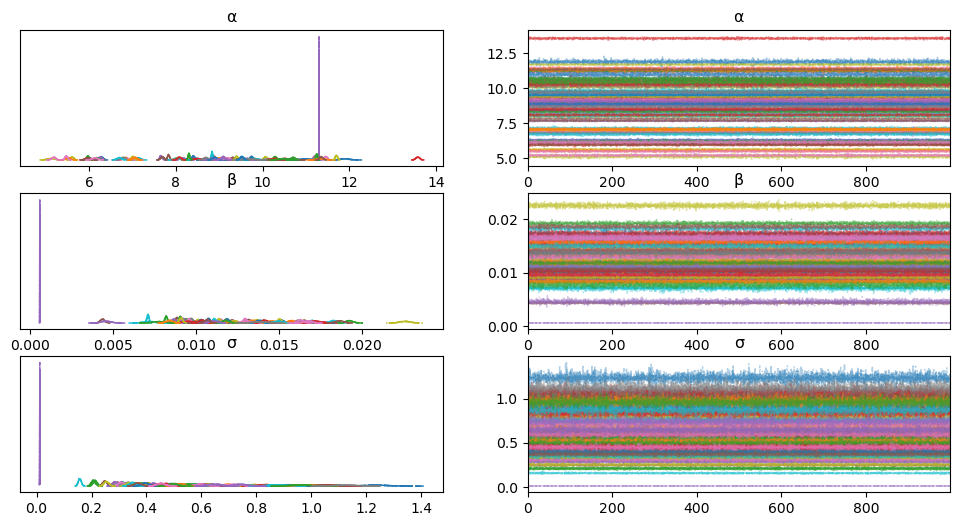

In [44]:
az.plot_trace(data=pooled, var_names=prior_vars);

/Users/22337766/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/plots/plot_utils.py:270: UserWarning:

rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (231) in plot_posterior, generating only 40 plots



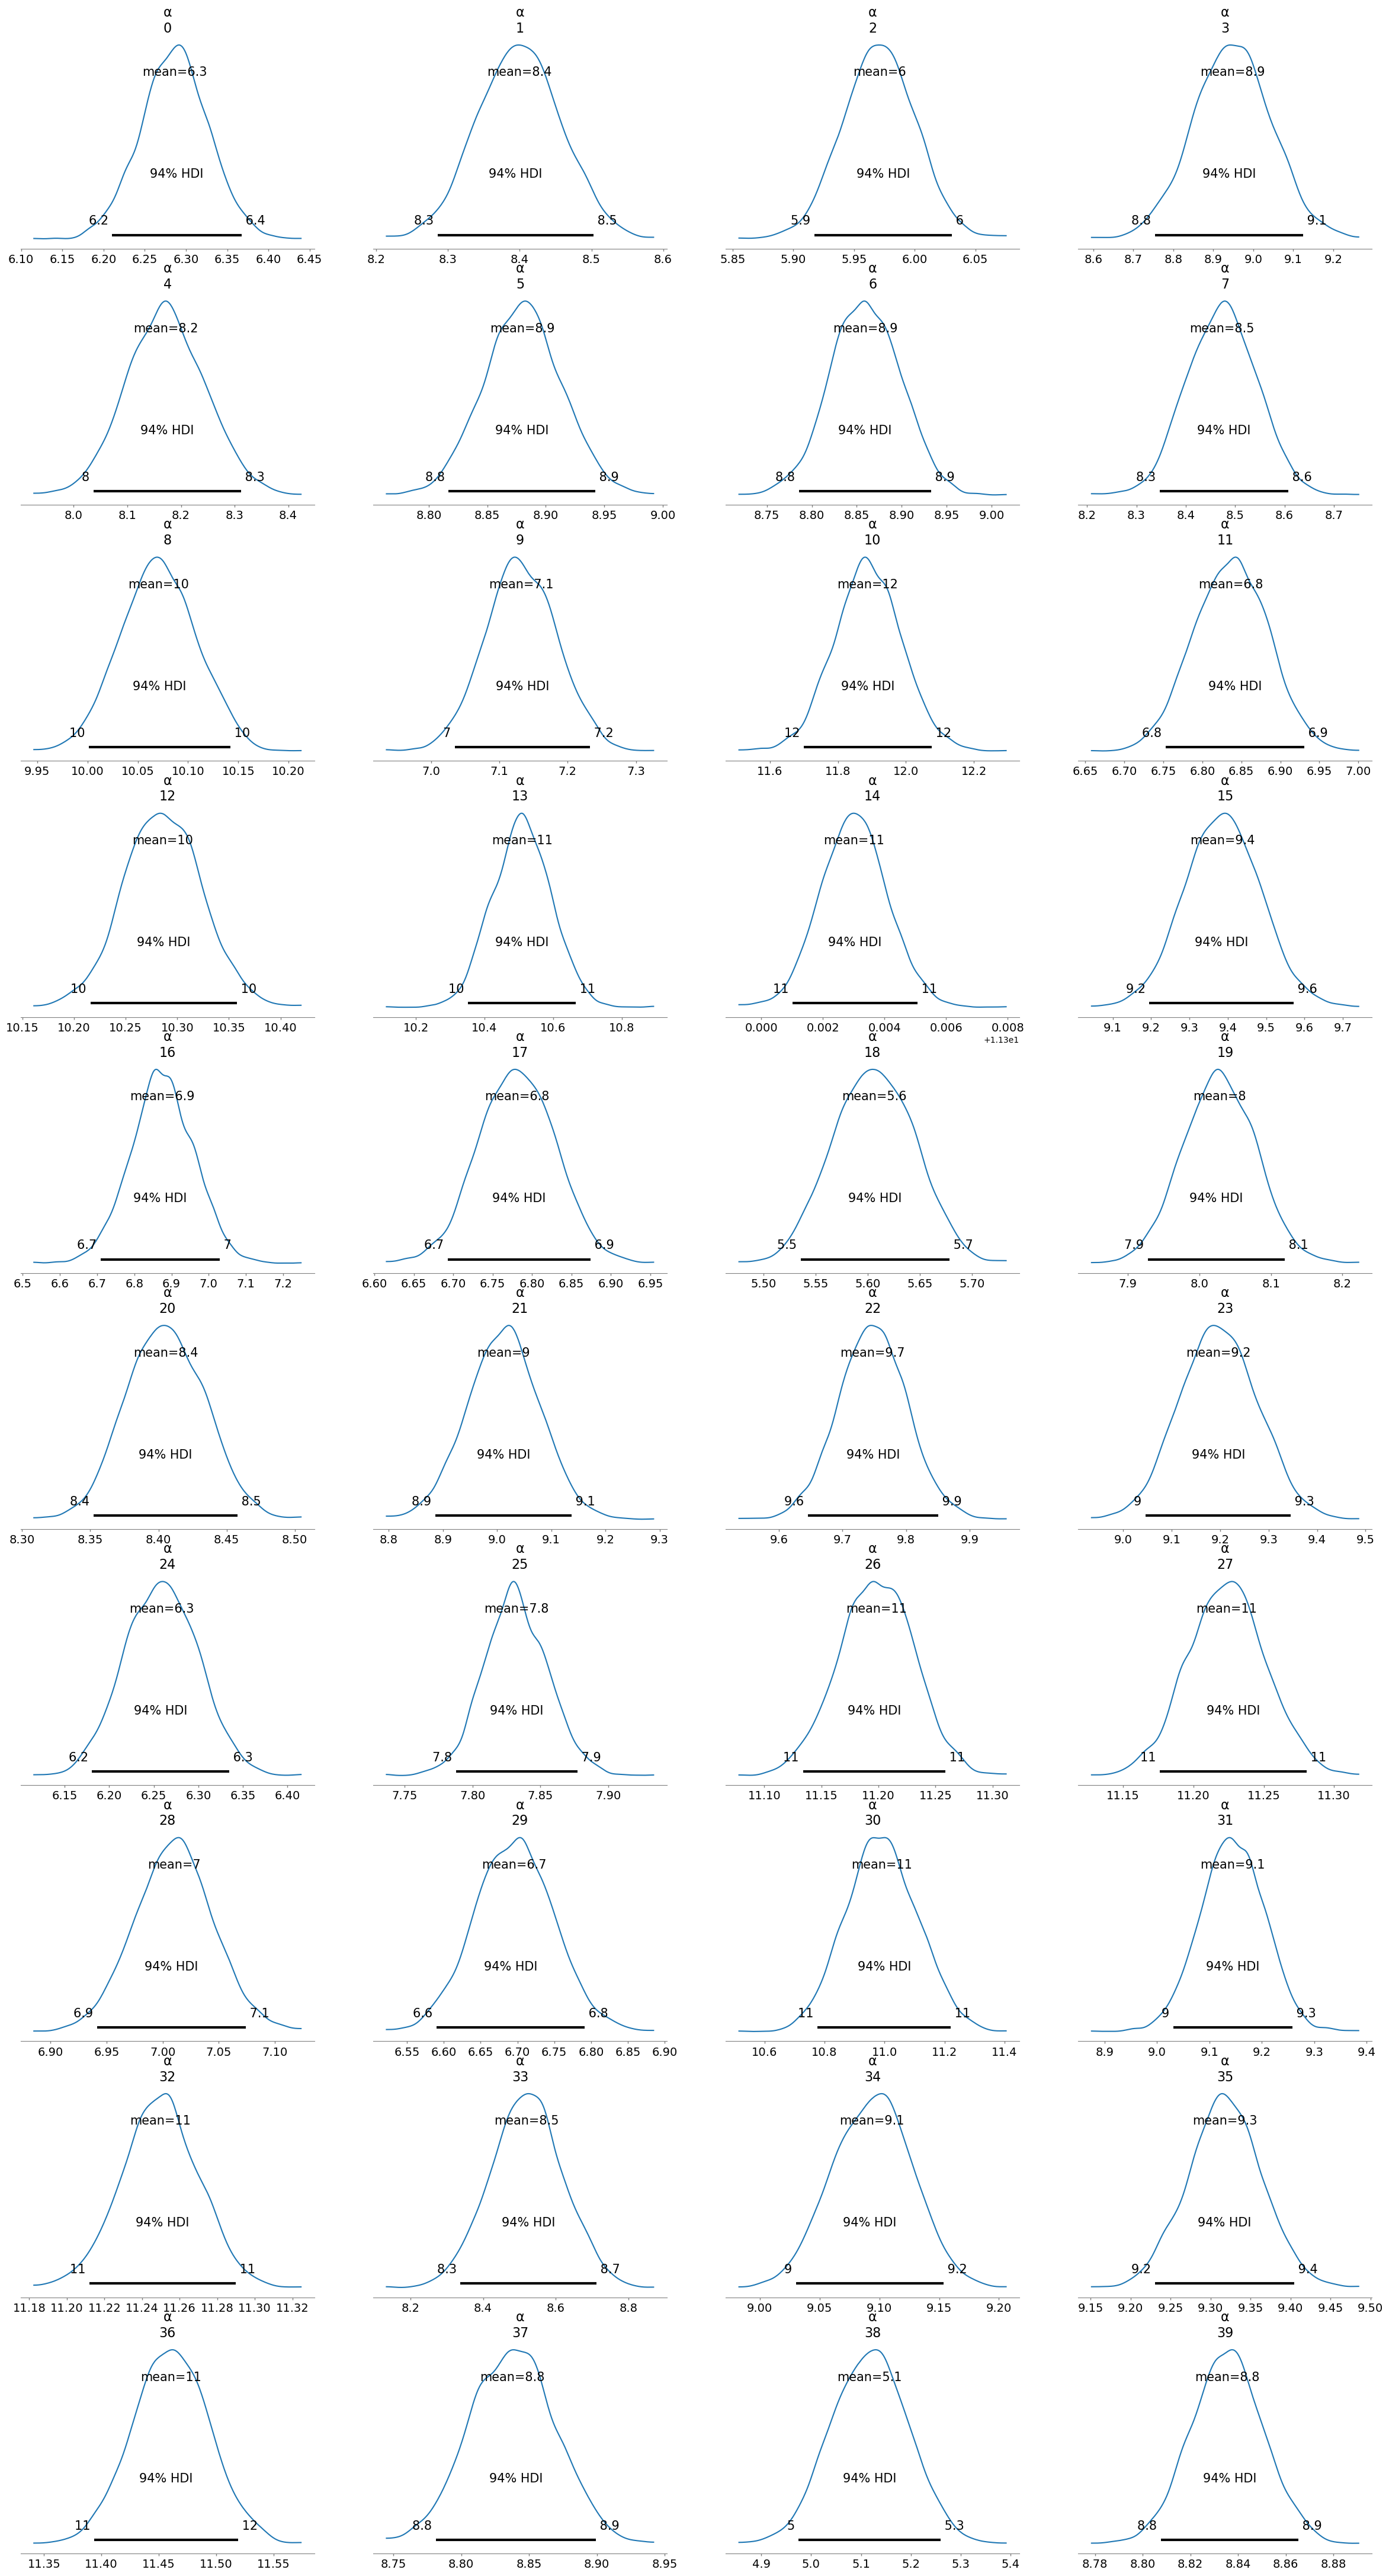

In [45]:
# Plotting posterior will give a combined view of all countries
az.plot_posterior(data=pooled, var_names=prior_vars, group='posterior');

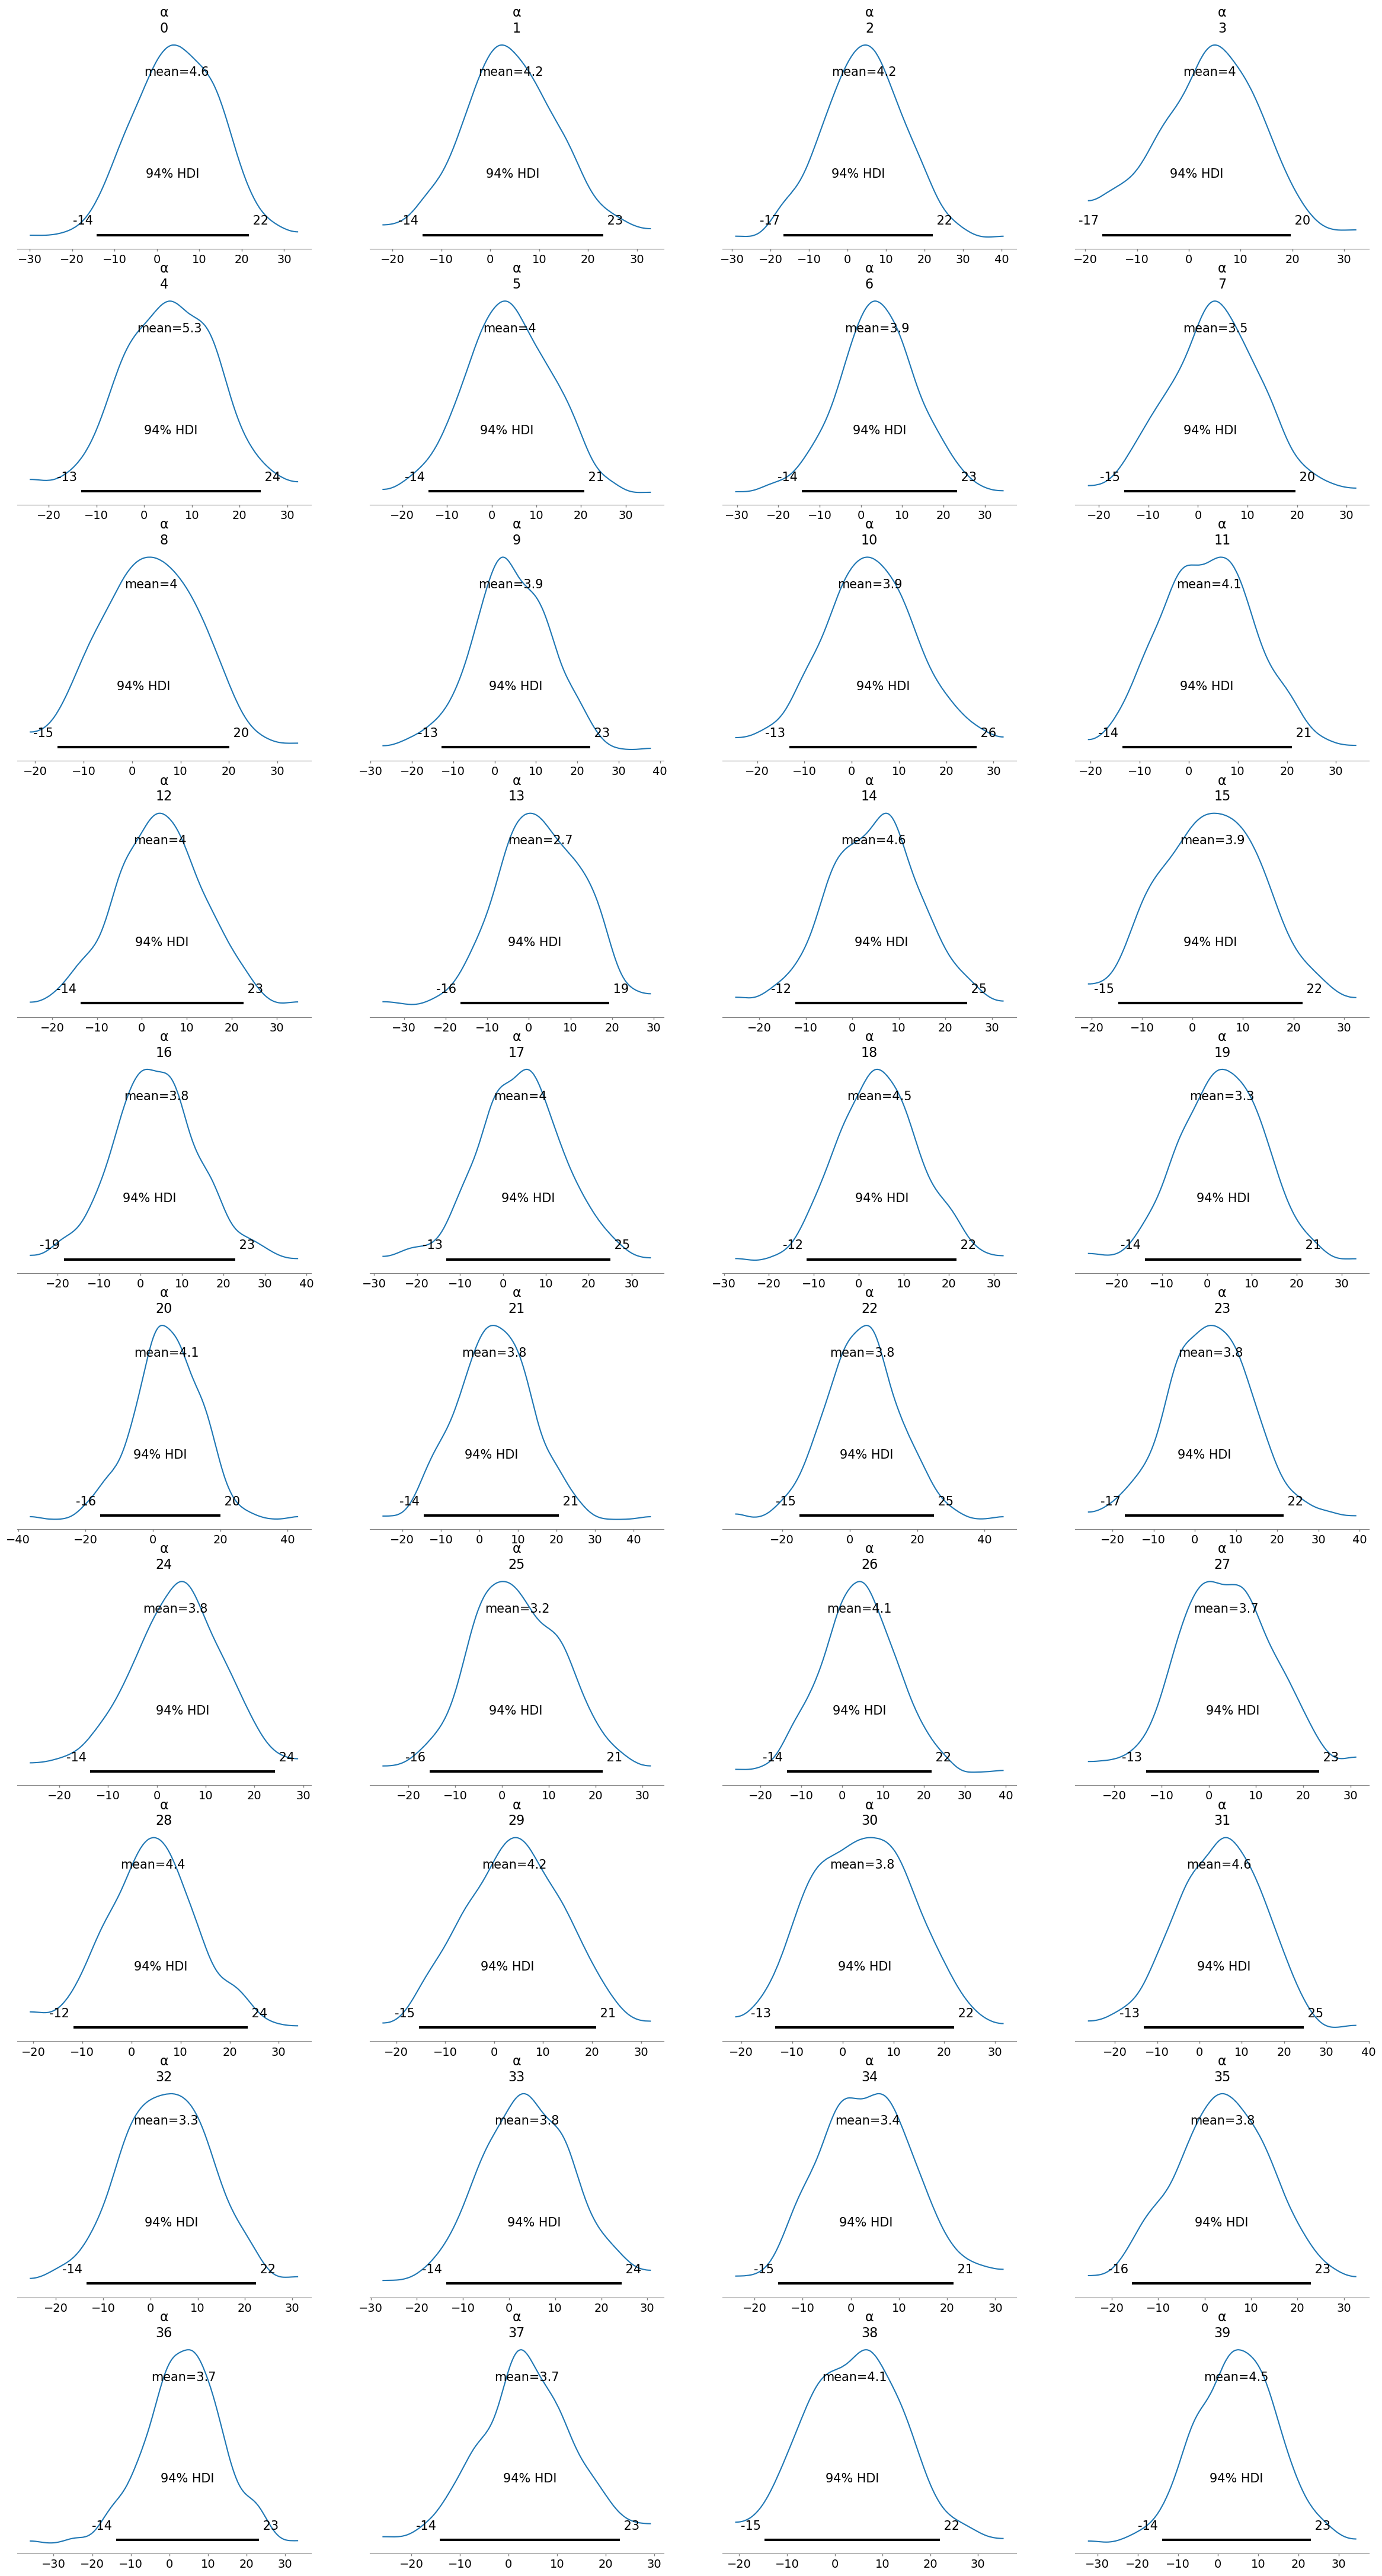

In [46]:
az.plot_posterior(data=pooled, var_names=prior_vars, group='prior');

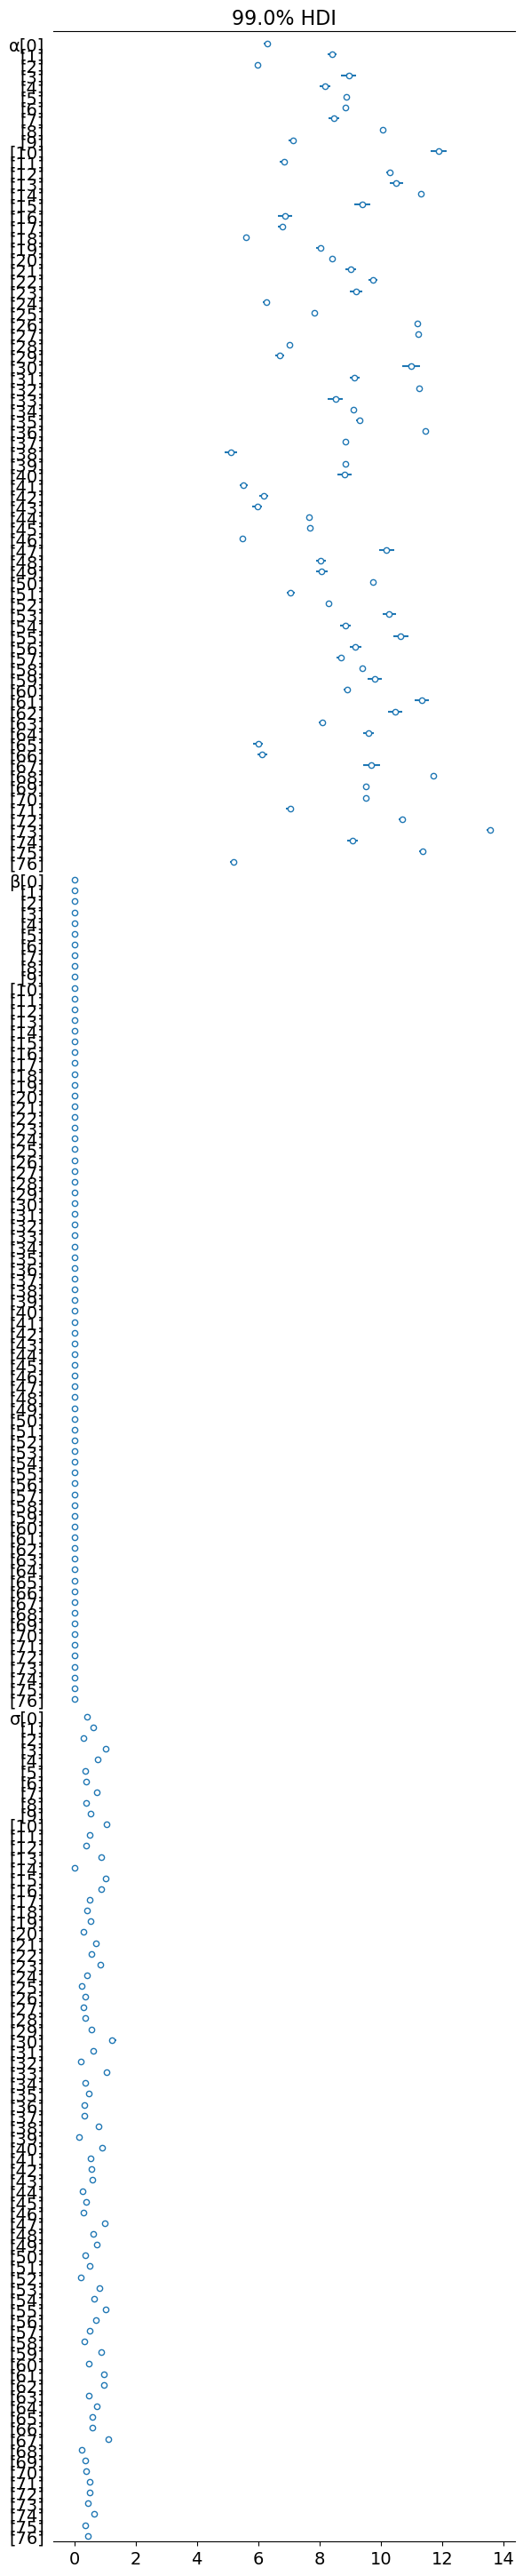

In [51]:
az.plot_forest(data=pooled, var_names=prior_vars, combined=True, hdi_prob=0.99);
plt.tight_layout()

In [52]:
# posterior_predictive = split_and_pack(data=pooled.posterior_predictive['pooled'].data, labels=countries, axis=2) # not working??
posterior_predictive = dict(zip(countries, np.split(ary=pooled.posterior_predictive['pooled'].data, axis=2, indices_or_sections=len(countries))))

X_countrywise = split_and_pack(data=pooled.constant_data['X'].data, labels=countries, axis=0)

# Y_countrywise = split_and_pack(data=pooled.constant_data['Y'].data, labels=countries, axis=0)
Y_countrywise = dict(zip(countries, np.split(ary=pooled.constant_data['Y'].data, axis=0, indices_or_sections=len(countries))))

In [54]:
@interact(country=countries)
def plot_countrywise_posterior(country):
    
    ci = 0.95
    
    plt.figure(figsize=(15, 10))

    az.plot_hdi(x=x, y=posterior_predictive[country], hdi_prob=ci);
    plt.plot(X_countrywise[country], Y_countrywise[country], label='Observed');
    
    y_fitted = means_df['α'][country] + means_df['β'][country]*X_countrywise[country]
    
    plt.plot(X_countrywise[country], y_fitted, label=f"{means_df['α'][country]} + {means_df['β'][country]}*x", color='k');

    plt.xlabel(f'Days Since {threshold}th Case')
    plt.ylabel('Natural Logarithm of Confirmed Cases')
    plt.title(country)
    plt.legend()
    plt.show()
    plt.close()
    
    bayesian_r2 = az.r2_score(y_true=Y_countrywise[country], y_pred=posterior_predictive[country].reshape(-1, Y_countrywise[country].shape[0]))
    y_fitted_bayesian = posterior_predictive[country].reshape(-1, Y_countrywise[country].shape[0]).mean(axis=0)
    print(f"Bayesian r2_score = {round(bayesian_r2['r2'], 2)}")
    print(f"Bayesian r2_score std = {round(bayesian_r2['r2_std'], 2)}")
    print('\n')
    print(f"Point(mean) r2_score = {round(r2_score(Y_countrywise[country], y_fitted_bayesian), 2)}")
    print(f"Point(mean) mean_squared_error = {round(mean_squared_error(Y_countrywise[country], y_fitted_bayesian), 2)}")

interactive(children=(Dropdown(description='country', options=('Albania', 'Algeria', 'Andorra', 'Argentina', '…

### Hierarchical Model

Shared hyper-priors but different priors for all countries

In [ ]:
x = np.arange(1, date_points + 1)
X = np.stack([x]*n_countries, axis=0)

Y = thresholded_high_confirmed_df.values

print(X.shape, Y.shape)

(14, 46) (14, 46)


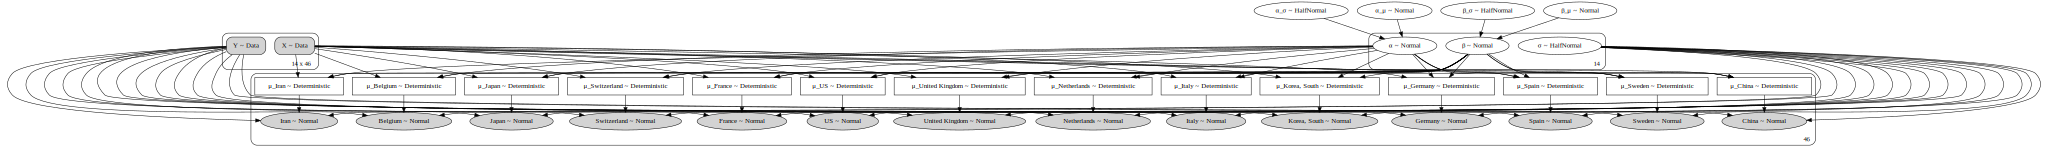

In [ ]:
# non-vectorised implementation
'''
All three parameters (mu, sd, observed) have to be of the same shape / broadcasteble
Here, 
    μ[i].shape = (40,)
    σ[i].shape = (1,) # broadcasted to (40,)
    Y[i].shape = (40,)
'''

with pm.Model() as hierarchical_model:

    X = pm.Data(name='X', value=X)
    Y = pm.Data(name='Y', value=Y) # not using it since we will iterate over the dataframe
    
    # hyper-priors
    α_μ = pm.Normal(name='α_μ', mu=int(np.log(threshold)), sd=10)
    α_σ = pm.HalfNormal(name='α_σ', sd=10)
    
    β_μ = pm.Normal(name='β_μ', sd=10)
    β_σ = pm.HalfNormal(name='β_σ', sd=10)
    
    # priors
    α = pm.Normal(name='α', mu=α_μ, sd=α_σ, shape=n_countries)
    β = pm.Normal(name='β', mu=β_μ, sd=β_σ, shape=n_countries)
    
    # error
    σ = pm.HalfNormal(name='σ', sd=10, shape=n_countries)
    
    # liklihood
    for i, (index, row) in enumerate(thresholded_high_confirmed_df.iterrows()):
        
        μ = pm.Deterministic(name=f'μ_{index}', var= α[i] + β[i]*X[i])
        pm.Normal(name=index, mu=μ, sd=σ[i], observed=Y[i])  # or observed=row.values
        
    pm.model_to_graphviz().save('hierarchical_model.png')
            
pm.model_to_graphviz(hierarchical_model)

In [ ]:
with hierarchical_model:
    
    # sampling liklihood
    prior = pm.sample_prior_predictive()
    
    # posterior
    trace = pm.sample()
    
    # predictions == 'posterior_predictive'
    pred = pm.sample_posterior_predictive(trace)

100%|██████████| 1000/1000 [03:56<00:00,  4.23it/s]


In [ ]:
hierarchical = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=pred, model=hierarchical_model)
prior_vars = ['α', 'β', 'σ']
hierarchical

Inference data with groups:
	> posterior
	> sample_stats
	> log_likelihood
	> posterior_predictive
	> observed_data
	> constant_data
	> prior
	> prior_predictive

In [ ]:
# pm.find_MAP(model=hierarchical_model)

In [ ]:
hierarchical.posterior['α'].shape # chains x samples x n_countries

(2, 500, 14)

In [ ]:
summary_df = az.summary(hierarchical) 
summary_df.to_csv('hierarchical_summary.csv')

In [ ]:
countries = thresholded_high_confirmed_df.index.to_list()
means = {var : split_and_pack(data=summary_df.filter(like=f"{var}[", axis=0)['mean'], labels=countries, axis=0) for var in prior_vars }
means_df = pd.DataFrame(means)

means_df

,α,β,σ
Belgium,5.510,0.129,0.496
China,11.294,0.001,0.002
France,7.359,0.116,0.443
Germany,7.515,0.117,0.639
Iran,8.861,0.062,0.194
Italy,9.287,0.074,0.398
Japan,5.857,0.074,0.128
"Korea, South",8.906,0.010,0.036
Netherlands,5.904,0.116,0.503
Spain,7.509,0.126,0.732


In [ ]:
# az.plot_trace(data=hierarchical, var_names=prior_vars);

In [ ]:
## Plotting posterior will give a combined view of all countries
# az.plot_posterior(data=hierarchical, var_names=prior_vars, group='posterior');

In [ ]:
# az.plot_posterior(data=hierarchical, var_names=prior_vars, group='prior');

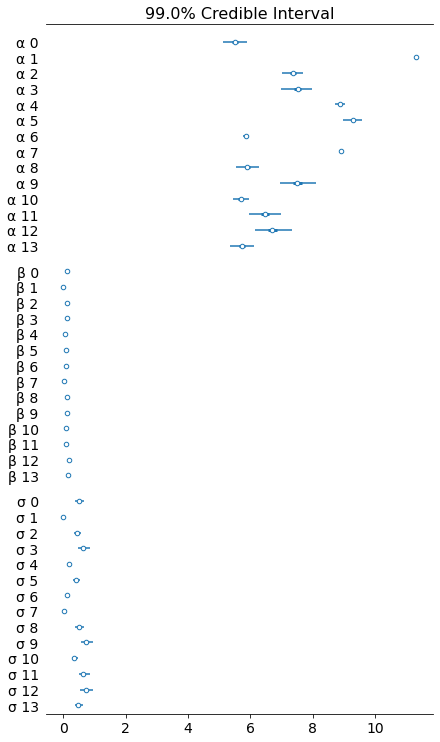

In [ ]:
az.plot_forest(data=hierarchical, var_names=prior_vars, combined=True, credible_interval=0.99);

In [ ]:
X_countrywise = split_and_pack(data=hierarchical.constant_data['X'].data, labels=countries, axis=0)
Y_countrywise = split_and_pack(data=hierarchical.constant_data['Y'].data, labels=countries, axis=0)

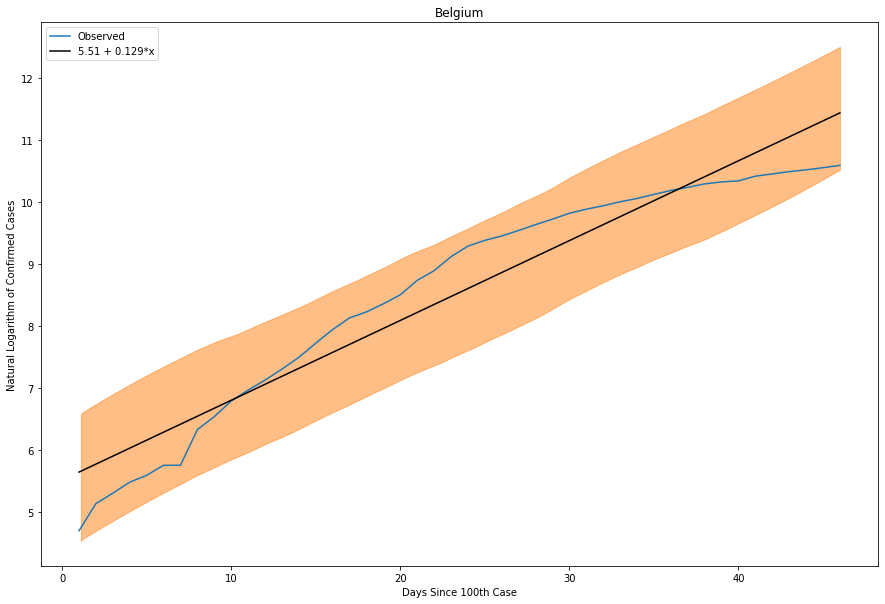

Bayesian r2_score = 0.92
Bayesian r2_score std = 0.0


Point(mean) r2_score = 0.93
Point(mean) mean_squared_error = 0.22


In [ ]:
@interact(country=countries)
def plot_countrywise_posterior(country):
    
    ci = 0.95
    
    plt.figure(figsize=(15, 10))

    az.plot_hpd(x=X_countrywise[country], y=hierarchical.posterior_predictive[country], credible_interval=ci);
    plt.plot(X_countrywise[country], Y_countrywise[country], label='Observed');
    
    y_fitted = means_df['α'][country] + means_df['β'][country]*X_countrywise[country]
    
    plt.plot(X_countrywise[country], y_fitted, label=f"{means_df['α'][country]} + {means_df['β'][country]}*x", color='k');

    plt.xlabel(f'Days Since {threshold}th Case')
    plt.ylabel('Natural Logarithm of Confirmed Cases')
    plt.title(country)
    plt.legend()
    plt.show()
    plt.close()
    
    bayesian_r2 = az.r2_score(y_true=Y_countrywise[country], y_pred=hierarchical.posterior_predictive[country].data.reshape(-1, Y_countrywise[country].shape[0]))
    y_fitted_bayesian = hierarchical.posterior_predictive[country].data.reshape(-1, Y_countrywise[country].shape[0]).mean(axis=0)
    print(f"Bayesian r2_score = {round(bayesian_r2['r2'], 2)}")
    print(f"Bayesian r2_score std = {round(bayesian_r2['r2_std'], 2)}")
    print('\n')
    print(f"Point(mean) r2_score = {round(r2_score(Y_countrywise[country], y_fitted_bayesian), 2)}")
    print(f"Point(mean) mean_squared_error = {round(mean_squared_error(Y_countrywise[country], y_fitted_bayesian), 2)}")

## Comparison

In [ ]:
datasets = {'unpooled' : unpooled,
           'pooled' : pooled,
           'hierarchical': hierarchical} 

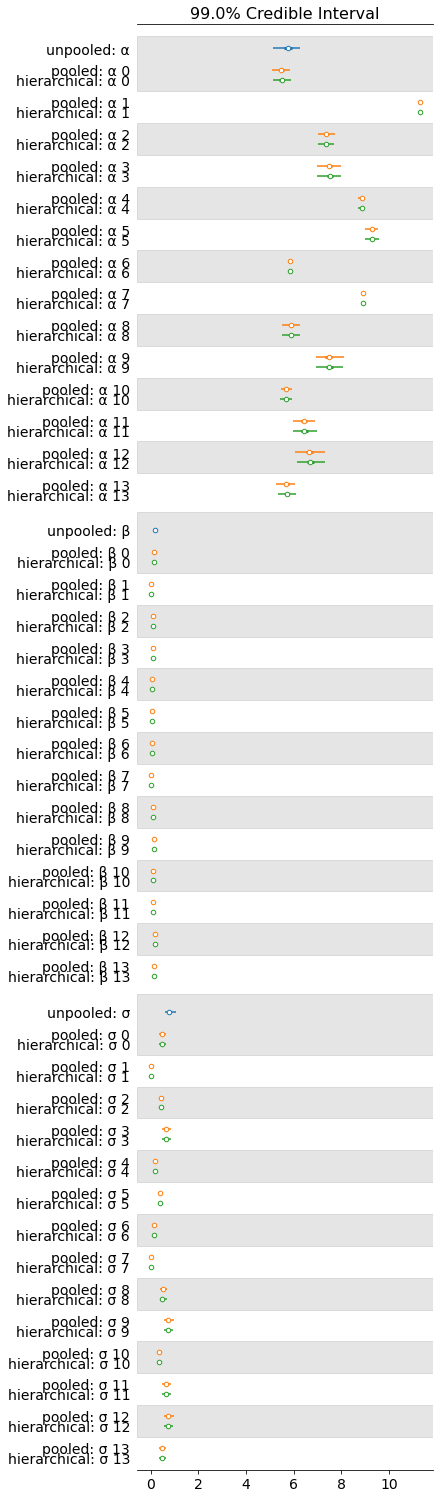

In [ ]:
az.plot_forest(data=list(datasets.values()), model_names=list(datasets.keys()), var_names=prior_vars, credible_interval=0.99, combined=True);
plt.savefig('comparison.png')

## To-Do:

1. Implement a different model for China and S. Korea (preferably logistic growth model).
2. Find the effect of intervention policy and try to determine the intervention date from the data.
3. Comment your suggestions 😁.